# Analyze results for 3D CGAN
Feb 22, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import subprocess as sp
import sys
import os
import glob
import pickle 

from matplotlib.colors import LogNorm, PowerNorm, Normalize
import seaborn as sns
from functools import reduce
import itertools

In [2]:
from ipywidgets import *

In [3]:
%matplotlib widget

In [4]:
sys.path.append('/global/u1/v/vpa/project/jpt_notebooks/Cosmology/Cosmo_GAN/repositories/cosmogan_pytorch/code/modules_image_analysis/')
from modules_img_analysis import *

In [5]:
sys.path.append('/global/u1/v/vpa/project/jpt_notebooks/Cosmology/Cosmo_GAN/repositories/cosmogan_pytorch/code/5_3d_cgan/1_main_code/')
import post_analysis_pandas as post


In [6]:
### Transformation functions for image pixel values
def f_transform(x,a):
    return 2.*x/(x + float(a)) - 1.

def f_invtransform(s,a):
    return float(a)*(1. + s)/(1. - s)

In [7]:
# img_size=64
# kappa=4
# kappa=10
kappa=50
img_size=128


In [9]:
val_data_dict={'64':'/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/3d_data/dataset2a_3dcgan_4univs_64cube_simple_splicing',
              '128':'/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/3d_data/dataset4_smoothing_4univ_cgan_varying_sigma_128cube'}

### Read validation data

In [ ]:
# bins=np.concatenate([np.array([-0.5]),np.arange(0.5,20.5,1),np.arange(20.5,100.5,5),np.arange(100.5,1000.5,50),np.array([2000])]) #bin edges to use
bins=np.concatenate([np.array([-0.5]),np.arange(0.5,100.5,5),np.arange(100.5,300.5,20),np.arange(300.5,1000.5,50),np.array([2000])]) #bin edges to use

bins=f_transform(bins,kappa)   ### scale to (-1,1)
# ### Extract validation data
sigma_lst=[0.5,0.65,0.8,1.1]
labels_lst=range(len(sigma_lst))
bkgnd_dict={}
num_bkgnd=100

for label in labels_lst:
#     fname=val_data_dict[str(img_size)]+'/norm_1_sig_{0}_train_val.npy'.format(sigma_lst[label])
    fname=val_data_dict[str(img_size)]+'/Om0.3_Sg%s_H70.0.npy'%(sigma_lst[label])
    print(fname)
    samples=np.load(fname,mmap_mode='r')[-num_bkgnd:][:,0,:,:]
    samples=f_transform(samples,kappa)
    dict_val=post.f_compute_hist_spect(samples,bins)
    bkgnd_dict[str(sigma_lst[label])]=dict_val
    del samples
    
    

/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/3d_data/dataset4_smoothing_4univ_cgan_varying_sigma_128cube/Om0.3_Sg0.5_H70.0.npy


## Read data

In [ ]:
# main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/128sq/'
# results_dir=main_dir+'20201002_064327'

In [ ]:
dict1={'64':'/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/',
      '128':'/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/'}

u=interactive(lambda x: dict1[x], x=Select(options=dict1.keys()))
# display(u)


In [ ]:
# parent_dir=u.result
parent_dir=dict1[str(img_size)]
dir_lst=[i.split('/')[-1] for i in glob.glob(parent_dir+'2023*')]
n=interactive(lambda x: x, x=Dropdown(options=dir_lst))
display(n)

In [ ]:
result=n.result
result_dir=parent_dir+result
print(result_dir)

## Plot Losses

In [ ]:
df_metrics=pd.read_pickle(result_dir+'/df_metrics.pkle').astype(np.float64)


In [ ]:
df_metrics.tail(10)

In [ ]:
def f_plot_metrics(df,col_list):
    
    plt.figure()
    for key in col_list:
        plt.plot(df_metrics[key],label=key,marker='*',linestyle='')
    plt.legend()
    plt.show()
#     col_list=list(col_list)
#     df.plot(kind='line',x='step',y=col_list)
    
# f_plot_metrics(df_metrics,['spec_chi','hist_chi'])

interact_manual(f_plot_metrics,df=fixed(df_metrics), col_list=SelectMultiple(options=df_metrics.columns.values))


In [ ]:

chi=df_metrics.quantile(q=0.2,axis=0)['hist_chi']
print(chi)
df_metrics[(df_metrics['hist_chi']<=chi)&(df_metrics.epoch>30)].sort_values(by=['hist_chi']).head(10)

In [ ]:
# display(df_metrics.sort_values(by=['hist_chi']).head(8))
# display(df_metrics.sort_values(by=['spec_chi']).head(8))

<!-- ### Read validation data -->

## Read stored chi-squares for images

In [ ]:
## Get sigma list from saved files
flist=glob.glob(result_dir+'/df_processed*')
sigma_lst=[i.split('/')[-1].split('df_processed_')[-1].split('.pkle')[0] for i in flist]
sigma_lst.sort() ### Sorting is important for labels to match !!

labels_lst=np.arange(len(sigma_lst))

In [ ]:
sigma_lst,labels_lst

In [ ]:
### Create a merged dataframe

df_list=[]
for label in labels_lst:
    df=pd.read_pickle(result_dir+'/df_processed_{0}.pkle'.format(str(sigma_lst[label])))
    df[['epoch','step']]=df[['epoch','step']].astype(int)
    df['label']=df.epoch.astype(str)+'-'+df.step.astype(str) # Add label column for plotting
    df_list.append(df)

for i,df in enumerate(df_list):
    df1=df.add_suffix('_'+str(i))
    # renaming the columns to be joined on
    keys=['epoch','step','img_type','label']
    rename_cols_dict={key+'_'+str(i):key for key in keys}
#     print(rename_cols_dict)
    df1.rename(columns=rename_cols_dict,inplace=True) 
    df_list[i]=df1
    
df_merged=reduce(lambda x, y : pd.merge(x, y, on = ['step','epoch','img_type','label']), df_list)

### Get sum of all 4 classes for 3 types of chi-squares
for chi_type in ['chi_1','chi_spec1','chi_spec2','chi_spec3','chi_1a','chi_1b','chi_1c']:
    keys=[chi_type+'_'+str(label) for label in labels_lst]
#     display(df_merged[keys].sum(axis=1))
    df_merged['sum_'+chi_type]=df_merged[keys].sum(axis=1)
del df_list


In [ ]:
# df_merged=df_merged[df_merged.epoch<106]

# df_merged=df_merged[(df_merged.epoch>100)&(df_merged.epoch<300)]

In [ ]:
df_merged.columns

### Slice best steps

In [ ]:
def f_slice_merged_df(df,cutoff=0.2,sort_col='chi_1',col_mode='all',label='all',params_lst=[0,1,2],head=10,epoch_range=[0,None],use_sum=True,display_flag=False):
    ''' View dataframe after slicing
    '''

    if epoch_range[1]==None: epoch_range[1]=df.max()['epoch']
    df=df[(df.epoch<=epoch_range[1])&(df.epoch>=epoch_range[0])]

    ######### Apply cutoff to keep reasonable chi1 and chispec1
    #### Add chi-square columns to use
    chi_cols=[]
    if use_sum: ## Add sum chi-square columns
        for j in ['chi_1','chi_spec1','chi_1a','chi_1b','chi_1c']: chi_cols.append('sum_'+j)
        
    if label=='all': ### Add chi-squares for all labels
        for j in ['chi_1','chi_spec1','chi_1a','chi_1b','chi_1c']:
            for idx,i in enumerate(params_lst): chi_cols.append(j+'_'+str(idx))
    else: ## Add chi-square for specific label
        assert label in params_lst, "label %s is not in %s"%(label,params_lst)
        label_idx=params_lst.index(label)
        print(label_idx)
        for j in ['chi_1','chi_spec1','chi_spec2','chi_1a','chi_1b','chi_1c']: chi_cols.append(j+'_'+str(label_idx))
#     print(chi_cols)
    q_dict=dict(df_merged.quantile(q=cutoff,axis=0)[chi_cols])
    # print(q_dict)
    strg=['%s < %s'%(key,q_dict[key]) for key in chi_cols ]
    query=" & ".join(strg)
    # print(query)
    df=df.query(query)
    
    # Sort dataframe
    df1=df[df.epoch>0].sort_values(by=sort_col)
    chis=[i for i in df_merged.columns if 'chi' in i]
    col_list=['label']+chis+['epoch','step']
    if (col_mode=='short'): 
        col_list=['label']+[i for i in df_merged.columns if i.startswith('sum')]
        col_list=['label']+chi_cols
    df2=df1.head(head)[col_list]
    
    if display_flag: display(df2) # Display df
    
    return df2

# f_slice_merged_df(df_merged,cutoff=0.3,sort_col='sum_chi_1',label=0.65,params_lst=[0.5,0.65,0.8,1.1],use_sum=True,head=2000,display_flag=False,epoch_range=[7,None])

In [ ]:
cols_to_sort=np.unique([i for i in df_merged.columns for j in ['chi_1_','chi_spec1_'] if ((i.startswith(j)) or (i.startswith('sum')))])

w=interactive(f_slice_merged_df,df=fixed(df_merged),
cutoff=widgets.FloatSlider(value=0.3, min=0, max=1.0, step=0.01), 
col_mode=['all','short'], display_flag=widgets.Checkbox(value=False),
use_sum=widgets.Checkbox(value=True),
label=ToggleButtons(options=['all']+sigma_lst), params_lst=fixed(sigma_lst),
head=widgets.IntSlider(value=10,min=1,max=20,step=1),
epoch_range=widgets.IntRangeSlider(value=[0,np.max(df.epoch.values)],min=0,max=np.max(df.epoch.values),step=1),
sort_col=cols_to_sort
)
display(w)

In [ ]:
# df_merged.tail(10)

In [ ]:
df_sliced=w.result
[int(i.split('-')[1]) for i in df_sliced.label.values]

df_sliced

### Choose best steps

In [ ]:
## Choose best_steps from sliced data
# best_step=df_sliced.step.values

In [ ]:
best_step=[]
df_test=df_merged.copy()
df_test=df_merged[((df_merged.epoch>100) & (df_merged.epoch<200))]
cut_off=1.0

best_step.append(f_slice_merged_df(df_test,cutoff=cut_off,sort_col='sum_chi_1',label='all',use_sum=True,head=4,display_flag=False,epoch_range=[7,None],params_lst=sigma_lst).step.values)
best_step.append(f_slice_merged_df(df_test,cutoff=cut_off,sort_col='sum_chi_spec1',label='all',use_sum=True,head=4,display_flag=False,epoch_range=[7,None],params_lst=sigma_lst).step.values)
best_step.append(f_slice_merged_df(df_test,cutoff=cut_off,sort_col='sum_chi_spec2',label='all',use_sum=True,head=4,display_flag=False,epoch_range=[7,None],params_lst=sigma_lst).step.values)
best_step.append(f_slice_merged_df(df_test,cutoff=cut_off,sort_col='sum_chi_spec3',label='all',use_sum=True,head=4,display_flag=False,epoch_range=[7,None],params_lst=sigma_lst).step.values)
# best_step.append(f_slice_merged_df(df_test,cutoff=cut_off,sort_col='sum_chi_1b',label='all',use_sum=True,head=2,display_flag=False,epoch_range=[7,None],params_lst=sigma_lst).step.values)

# best_step.append([46669,34281])
best_step=np.unique([i for j in best_step for i in j])
print(best_step)
best_step

In [ ]:
# best_step=[6176]
# best_step= [23985,24570,25155,25740,26325,26910,27495]
# best_step=[int(i.split('-')[1]) for i in df_sliced.label.values]
# best_step=np.arange(40130,40135).astype(int)

In [ ]:
### Choose uniformly distributed steps for seeing mode collapse
# best_step=df_merged.step.values[::300]

In [ ]:
# # Pick out last few steps for testing stability
# best_step=df_merged.step.values[-10:]

### Get best data in dataframe

In [ ]:
df_best=df_merged[df_merged.step.isin(best_step)]
print(df_best.shape)
print([(df_best[df_best.step==step].epoch.values[0],df_best[df_best.step==step].step.values[0]) for step in best_step])
# print([(df_best.loc[idx].epoch,df_best.loc[idx].step) for idx in best_idx])

In [ ]:
col_list=['label']+[i for i in df_merged.columns if i.startswith('sum')]
df_best[col_list]

### Interactive plot

In [ ]:
def f_plot_1d_sum(arr):
    
    # Ensure 4D array: samples,x,y,z
    assert len(arr.shape)==4, "Array must have only 4 dimensions %s. You have "%(arr.shape[0])
    assert np.min(arr)>=0, "Array has negative values. Need to be all positive for sum. min:%s\t max:%s"%(np.min(arr),np.max(arr))

    num_images=arr.shape[0]

    if num_images> 30:
        print("Too many images. Need less than or equal to 15",arr.shape)
        raise SystemExit
        
    # Get array summed along y and z axes
    a1=np.sum(arr,axis=(2,3))

#     ## Compute l1-norm for 1D array
#     b_arr=np.arange(num_images)

#     # Pick pairs of indices to compute l1-norm
#     b1=np.random.choice(b_arr,num_images//2,replace=False)
#     b2=np.array([i for i in b_arr if i not in b1])

#     val=np.zeros(num_images//2)
#     for count,(i1,i2) in enumerate(zip(b1,b2)):
#         val[count]=abs(a1[i1]-a1[i2]).sum()
        # print(np.sum(a1[i1]),np.sum(a1[i2]),np.sum(val))
    
    # print(val)
    
    fig=plt.figure()
    
    
#     fig.add_subplot(1,2,1)
#     plt.plot(val,marker='o')
    
#     fig.add_subplot(1,2,2)
#     for count,(i,marker) in enumerate(zip(arr,itertools.cycle('>^*sDHPdpx_'))):
#         plt.plot(a1[count],label=str(count),marker=marker)
        
    
    fig.add_subplot(1,1,1)
    for count,(i,marker) in enumerate(zip(arr,itertools.cycle('>^*sDHPdpx_'))):
        plt.plot(a1[count],label=str(count),marker=marker)
        
    
    plt.legend()
    plt.show()

In [ ]:
def f_print_sdev_1d(arr):
    
    # c1=np.sum(arr,axis=(2,3))
    # sd=np.std(c1,axis=0)
    
    # Compute Std deviation among images. img[idx,x,y,z]
    ## axis=0 because you need variation over image index 
    sd1=np.std(arr,axis=0)[:,0,0]/np.sum(arr)
    sd2=np.std(arr,axis=0)[0,:,0]/np.sum(arr)
    sd3=np.std(arr,axis=0)[0,0,:]/np.sum(arr)
    
    return np.sum(sd1),np.sum(sd2),np.sum(sd3)

In [ ]:

def f_plot_hist_spec(df,param_labels,sigma_lst,steps_list,bkg_dict,plot_type,img_size):

    assert plot_type in ['hist','spec','grid_2dslice','grid_zsum','spec_relative','1d_sum','1d_sdev'],"Invalid mode %s"%(plot_type)

    if plot_type in ['hist','spec','spec_relative']:     fig=plt.figure(figsize=(6,6))
    for par_label in param_labels:
        df=df[df.step.isin(steps_list)]
#         print(df.shape)
        idx=sigma_lst.index(par_label)
        suffix='_%s'%(idx)
        dict_bkg=bkg_dict[str(par_label)]
        
        for (i,row),marker in zip(df.iterrows(),itertools.cycle('>^*sDHPdpx_')):
            label=row.label+'_'+str(par_label)
            if plot_type=='hist':
                x1=row['hist_bin_centers'+suffix]
                y1=row['hist_val'+suffix]
                yerr1=row['hist_err'+suffix]
                x1=f_invtransform(x1,kappa)
                
                plt.errorbar(x1,y1,yerr1,marker=marker,markersize=5,linestyle='',label=label)
            if plot_type=='spec':
                y2=row['spec_val'+suffix]
                yerr2=row['spec_sdev'+suffix]/np.sqrt(row['num_imgs'+suffix])
                x2=np.arange(len(y2))
                y2=x2**2*y2; yerr2=x2**2*yerr2 ## Plot k^2 P(y)
                plt.fill_between(x2, y2 - yerr2, y2 + yerr2, alpha=0.4)
                plt.plot(x2, y2, marker=marker, linestyle=':',label=label)

            if plot_type=='spec_relative':

                y2=row['spec_val'+suffix]
                yerr2=row['spec_sdev'+suffix]
                x2=np.arange(len(y2))

                ### Reference spectrum
                y1,yerr1=dict_bkg['spec_val'],dict_bkg['spec_sdev']
                y=y2/y1
                ## Variance is sum of variance of both variables, since they are uncorrelated

                # delta_r= |r| * sqrt(delta_a/a)^2 +(\delta_b/b)^2) / \sqrt(N)
                yerr=(np.abs(y))*np.sqrt((yerr1/y1)**2+(yerr2/y2)**2)/np.sqrt(row['num_imgs'+suffix])
                
                plt.fill_between(x2, y - yerr, y + yerr, alpha=0.4)
                plt.plot(x2, y, marker=marker, linestyle=':',label=label)

            if plot_type=='grid_2dslice':
                images=np.load(row['fname'+suffix])[:,0,:,:,:]
                print(row['fname'+suffix])
                
                images=images[:,:,:,img_size//2] ## Pick z slice
                print(np.max(images),np.min(images))    

                f_plot_grid(images[:8],cols=4,fig_size=(8,4))

            if plot_type=='grid_zsum':
                images=np.load(row['fname'+suffix])[:,0,:,:,:]
                # print(row['fname'+suffix])
                # print(images.shape)
                
                # print(np.max(f_invtransform(images,kappa)))
                images=np.sum(f_invtransform(images,kappa),axis=3)
                # images=f_transform(np.sum(f_invtransform(images,kappa),axis=3),kappa)
                
                print(np.max(images),np.min(images))
                
                f_plot_grid(images[:8],cols=4,fig_size=(8,4))
                
                
            if plot_type=='1d_sum':
                images=np.load(row['fname'+suffix])[:,0,:,:,:]
                
                f_plot_1d_sum(f_invtransform(images[:8],kappa))
                
            if plot_type=='1d_sdev':
                images=np.load(row['fname'+suffix])[:,0,:,:,:]
                print(f_print_sdev_1d(f_invtransform(images[:8],kappa)))          
                
        ### Plot reference data
        if plot_type=='hist':
            x,y,yerr=dict_bkg['hist_bin_centers'],dict_bkg['hist_val'],dict_bkg['hist_err']
            x=f_invtransform(x,kappa)
            plt.errorbar(x, y,yerr,color='k',linestyle='-',label='bkgnd')   
            plt.title('Pixel Intensity Histogram')
            plt.xscale('symlog',linthresh=50)
        
        if plot_type=='spec':
            y,yerr=dict_bkg['spec_val'],dict_bkg['spec_sdev']/np.sqrt(num_bkgnd)
            x=np.arange(len(y))
            y=x**2*y; yerr=x**2*yerr ## Plot k^2 P(y)
            plt.fill_between(x, y - yerr, y + yerr, color='k',alpha=0.8)
            plt.title('Spectrum')
            plt.xlim(0,img_size/2)

        if plot_type=='spec_relative':
            plt.axhline(y=1.0,color='k',linestyle='-.')
            plt.title("Relative spectrum")
            plt.xlim(0,img_size/2)
            plt.ylim(0.5,2)

    if plot_type in ['hist','spec']:     
        plt.yscale('log')
    if plot_type in ['hist','spec','spec_relative']: 
        plt.legend(bbox_to_anchor=(0.3, 0.75),ncol=2, fancybox=True, shadow=True,prop={'size':6})
        plt.show()

# f_plot_hist_spec(df_merged,[sigma_lst[-1]],sigma_lst,[best_step[0]],bkgnd_dict,'hist')

In [ ]:
interact_manual(f_plot_hist_spec,df=fixed(df_best),
                param_labels=SelectMultiple(options=sigma_lst),sigma_lst=fixed(sigma_lst),
                steps_list=SelectMultiple(options=df_best.step.values),
                img_size=fixed(img_size),
                bkg_dict=fixed(bkgnd_dict),plot_type=ToggleButtons(options=['hist','spec','spec_relative','grid_2dslice','grid_zsum','1d_sum','1d_sdev']))


### Plots for reference images


In [166]:
def f_ref_plot(images,img_size,plot_type):
    assert plot_type in ['grid_2dslice','grid_zsum','1d_sum','1d_sdev'], "plot type must be in %s"%(plot_type)
    
    if plot_type=='grid_2dslice': ### 2D slice
        images=a_ref[:,:,:,img_size//2] ## Pick z slice
        # print(np.max(images),np.min(images))    
        f_plot_grid(images[:8],cols=4,fig_size=(8,4))
        
    elif plot_type=='grid_zsum': ## Grid z sum 
        images=np.sum(f_invtransform(a_ref,kappa),axis=3)
        # print(np.max(images),np.min(images))
        f_plot_grid(images[:8],cols=4,fig_size=(8,4))
        
    elif plot_type=='1d_sum':  ## 1D sum
        f_plot_1d_sum(f_invtransform(images[:8],kappa))
        
    elif plot_type=='1d_sdev':
        sd_metric=f_plot_sdev_1d(images[:8],0)
        print(sd_metric)
        
        
# f_ref_plot(a_ref,img_size,'grid_2dslice')

In [198]:
##### Ref images
sigma=0.8
fname1='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/3d_data/dataset4_smoothing_4univ_cgan_varying_sigma_128cube/Om0.3_Sg%s_H70.0.npy'%(sigma)
a_ref=np.load(fname1,mmap_mode='r')[740:760,0,:,:,:]
a_ref=f_transform(a_ref,kappa)

In [197]:
interact_manual(f_ref_plot,images=fixed(a_ref), img_size=fixed(img_size),
                plot_type=ToggleButtons(options=['grid_2dslice','grid_zsum','1d_sum','1d_sdev']))


interactive(children=(ToggleButtons(description='plot_type', options=('grid_2dslice', 'grid_zsum', '1d_sum', '…

<function __main__.f_ref_plot(images, img_size, plot_type)>

### Check mode collapse

In [262]:

# GAN images
print(result_dir)
fname2=glob.glob(result_dir+'/images/gen_img_label-0.8_epoch-*_step-107750.npy')[0]
b1=np.load(fname2,mmap_mode='r')[:20,0,:,:,:]
b1=f_invtransform(b1,kappa)

fname3=result_dir+'/images/inference_label-0.8_epoch-246_step-61390.npy'
b2=np.load(fname3,mmap_mode='r')[:20,0,:,:,:]
b2=f_invtransform(b2,kappa)

fname3=glob.glob(result_dir+'/images/gen_img_label-0.8_epoch-*_step-10.npy')[0]
b3=np.load(fname3,mmap_mode='r')[:20,0,:,:,:]
b3=f_invtransform(b3,kappa)


/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20230424_94133_cgan_128_lr0.0002_sp0.1_kappa50_upsampling


IndexError: list index out of range

In [263]:
a1.shape,b1.shape,np.max(a1),np.max(b1),np.min(b1)

((20, 128, 128, 128), (8, 128, 128, 128), 743.89404, 1251.2927, 6.258496e-05)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
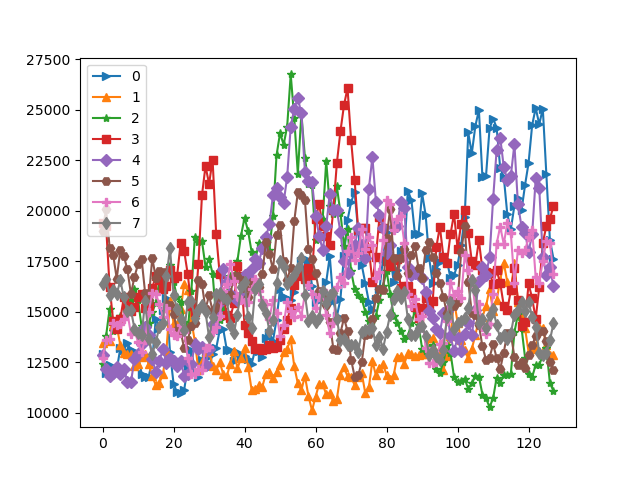

Text(0.5, 1.0, 'Reference images')

In [264]:
f_plot_1d_sum(a1[:8])
plt.title("Reference images")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
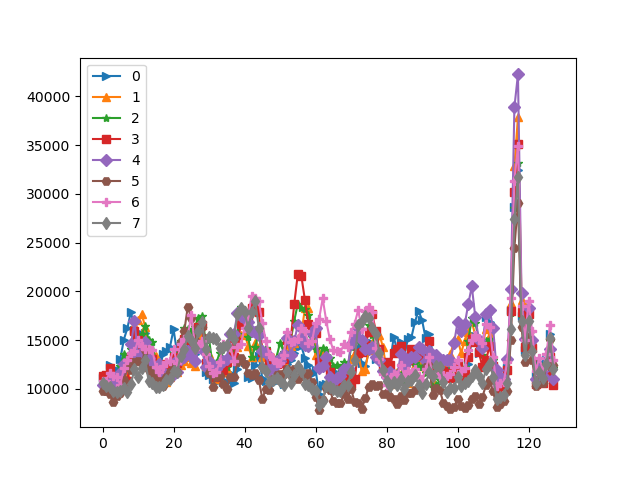

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
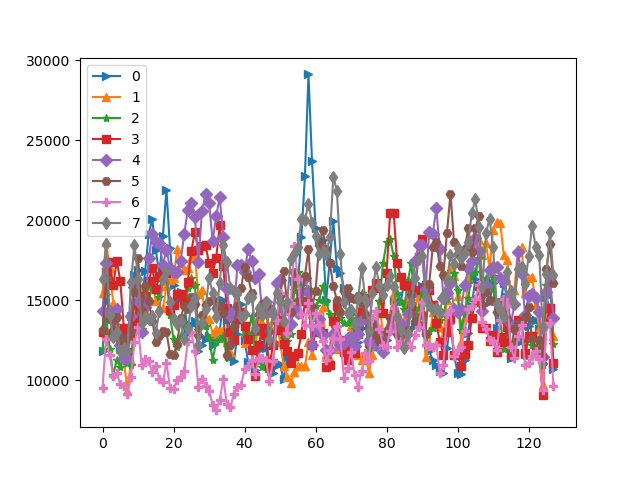

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
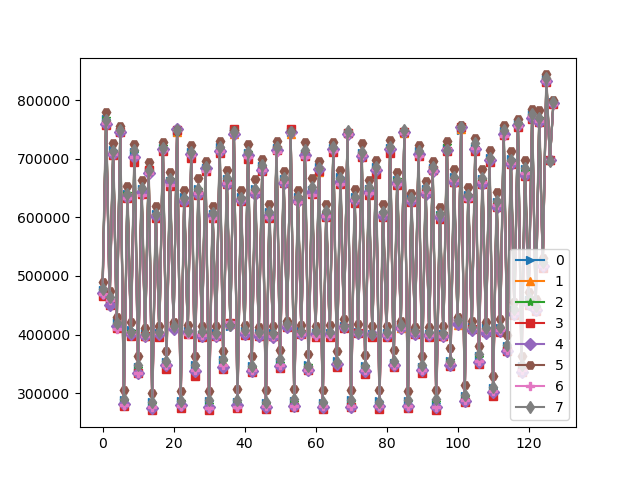

(None, None, None)

In [265]:
f_plot_1d_sum(b1[:8]),f_plot_1d_sum(b2[:8]), f_plot_1d_sum(b3[:8])

### Image subtraction metric

In [45]:
def f_img_subtract(arr,idx1,idx2):
    return np.sum(np.abs(arr[idx1,:]-arr[idx2,:]))


for arr in [a1,b1,b2,b3]:
    print(f_img_subtract(arr,0,1))


2450162.2
1810829.0
2491607.2
21287010.0


In [89]:
def f_plot_sdev_1d(arr,plot=False):
    
    # c1=np.sum(arr,axis=(2,3))
    # sd=np.std(c1,axis=0)
    
    # print(arr.shape)
    # Compute Std deviation among images,
    sd1=np.std(arr,axis=0)[:,0,0]/np.sum(arr)
    sd2=np.std(arr,axis=0)[0,:,0]/np.sum(arr)
    sd3=np.std(arr,axis=0)[0,0,:]/np.sum(arr)
    # print(sd.shape)
    
    if plot: 
        plt.figure()
        plt.plot(sd1,marker='o',linestyle='-')
        plt.show()
    
    return np.sum(sd1),np.sum(sd2),np.sum(sd3)
    

for arr in [a1,b1,b2,b3]:
    sd_metric=f_plot_sdev_1d(arr[:8],0)
    print(sd_metric)

(8.846709e-06, 9.846146e-06, 9.113383e-06)
(1.0925218e-06, 2.4971903e-06, 3.2081753e-06)
(1.0021132e-05, 4.39163e-06, 2.332379e-06)
(1.694637e-06, 1.6648614e-06, 1.6316249e-06)


### Delete unwanted stored models
(Since deterministic runs aren't working well )

In [ ]:
# # fldr='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/128sq/20210119_134802_cgan_predict_0.65_m2/models'
# fldr='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20230208_111749_cgan_128_lr0.0002_fm00_sp0.1_kappa10_gpus3_newspecloss_no_var_good_run'
# fldr=result_dir
# print(fldr)
# flist=glob.glob(fldr+'/models/checkpoint_*.tar')
# len(flist)

In [ ]:
# # Delete unwanted stored images
# # !! Use with caution !! 
# for i in flist:
#     try:
#         step=int(i.split('/')[-1].split('_')[-1].split('.')[0])
#         if ( (step < 25140) or (step > 99850)):
#         # if step not in best_step:
#             print("removing", step)
#             #### os.remove(i)
#         else: 
#             pass
#             # print(step)
# #             print(i)
#     except Exception as e:
# #         print(e)
# #         print(i)
#         pass

In [ ]:
# np.unique(df_merged[df_merged.epoch<101].step.values)
# np.unique(df_merged[df_merged.epoch>400].step.values)

In [ ]:
# ! du -hs  /global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/3d_data/dataset2a_3dcgan_4univs_64cube_simple_splicing/norm_1_sig_0.5_train_val.npy